### 06. Count the pairs of victimisation experiences and observations.

---
In this section, we use the two tables from the previous sections to combine the two different mechanisms.

**Things to do**
* Test the results.
* Make code modular (create a function for plotting).

In [1]:
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read a summary table of the victimisation-based mechanism.
PATH_TO_VIC_DATA = "s3://social-research-cheating/summary-tables/emp-net/vic/vic_30.parquet"
vic_data = spark.read.parquet(PATH_TO_VIC_DATA)
vic_data.registerTempTable("vic_data")

# Read a summary table of the observation-based mechanism.
PATH_TO_OBS_DATA = "s3://social-research-cheating/summary-tables/emp-net/obs/rev_obs_30_2.parquet"
obs_data = spark.read.parquet(PATH_TO_OBS_DATA)
obs_data.registerTempTable("obs_data")

In [3]:
# Collect the transitions that happened within seven days after observing or being killed by cheating.
vic_tab = spark.sql("SELECT * FROM vic_data WHERE period <= 7")
obs_tab = spark.sql("SELECT * FROM obs_data WHERE period <= 7")

vic_tab.registerTempTable("vic_tab")
obs_tab.registerTempTable("obs_tab")

In [4]:
# Show the first few rows of each dataset.
vic_tab.show(5)
obs_tab.show(5)

# Convert spark dataframes into pandas dataframes.
obs_df = obs_tab.toPandas()
vic_df = vic_tab.toPandas()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.393b6ee09...|2019-03-08|2019-03-01|     7|        2|            1|           2|
|account.3f888b606...|2019-03-10|2019-03-05|     5|        7|            4|           7|
|account.4b6c650bd...|2019-03-15|2019-03-11|     4|        2|            0|           2|
|account.73e50018a...|2019-03-27|2019-03-20|     7|        1|            1|           1|
|account.b3e7bbe4a...|2019-03-09|2019-03-04|     5|        1|            0|           1|
+--------------------+----------+----------+------+---------+-------------+------------+
only showing top 5 rows

+--------------------+----------+----------+------+---------+-------------+--------------+------------+
|                  id|start_date|    m_date|period|total_obs|total_sev

### 1. Merge two tables.

In [5]:
# Create a table that contains player (cheater) IDs and the start dates of cheating adoption for each cheater
dates_obs = obs_df[['id', 'start_date']]
dates_vic = vic_df[['id', 'start_date']]
dates_df = pd.concat([dates_obs, dates_vic])
dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
dates_df = spark.createDataFrame(dates_df)
dates_df.registerTempTable("dates_df")
dates_df.show(10)

+--------------------+----------+
|                  id|start_date|
+--------------------+----------+
|account.14a9052f2...|2019-03-08|
|account.b5b8daec9...|2019-03-03|
|account.826ffb6b1...|2019-03-10|
|account.89e89a88e...|2019-03-08|
|account.d09650395...|2019-03-10|
|account.d5bdf5693...|2019-03-05|
|account.516b36389...|2019-03-05|
|account.72d7c8781...|2019-03-06|
|account.22f135474...|2019-03-07|
|account.bed69e8d7...|2019-03-03|
+--------------------+----------+
only showing top 10 rows



In [6]:
add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                            CASE WHEN total_cheaters IS NULL THEN 0 ELSE total_cheaters END AS total_obs, 
                            CASE WHEN sev_cheaters IS NULL THEN 0 ELSE sev_cheaters END AS sev_obs 
                            FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
add_obs_info.registerTempTable("add_obs_info")

merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                         CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                         CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                         FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
merged_df.show(10)

+--------------------+----------+---------+-------+---------+-------+
|                  id|start_date|total_obs|sev_obs|total_exp|sev_exp|
+--------------------+----------+---------+-------+---------+-------+
|account.14a9052f2...|2019-03-08|       27|      3|        6|      3|
|account.b5b8daec9...|2019-03-03|        2|      0|        0|      0|
|account.826ffb6b1...|2019-03-10|        2|      0|        0|      0|
|account.89e89a88e...|2019-03-08|       10|      5|        3|      2|
|account.d09650395...|2019-03-10|        3|      1|        1|      0|
|account.d5bdf5693...|2019-03-05|        2|      0|        0|      0|
|account.516b36389...|2019-03-05|        2|      0|        0|      0|
|account.72d7c8781...|2019-03-06|       13|      2|        0|      0|
|account.22f135474...|2019-03-07|        2|      0|        0|      0|
|account.bed69e8d7...|2019-03-03|        4|      0|        0|      0|
+--------------------+----------+---------+-------+---------+-------+
only showing top 10 

### 2. Plot the distribution of experiences and observations.

In [7]:
merged_tab = merged_df.toPandas()
pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")

# Print the first 5 and last 5 rows.
print(pairs_tab.head())
print(pairs_tab.tail())

   total_obs  total_exp  freq
0          0          0   183
1          0          1   101
2          0          2    22
3          0          3     9
4          0          4     1
     total_obs  total_exp  freq
115         43          3     1
116         58          7     1
117         64          4     1
118         65          2     1
119        100          2     1


In [8]:
# Store the dataframe as an excel file.
pairs_tab.to_csv('emp_data.csv', index=False)

In [9]:
merged_tab = merged_df.toPandas()
sev_pairs_tab = merged_tab.groupby(['total_obs', 'sev_exp']).size().reset_index(name="freq")

# Print the first 5 and last 5 rows.
print(sev_pairs_tab.head())
print(sev_pairs_tab.tail())

# Store the dataframe as an excel file.
sev_pairs_tab.to_csv('sev_emp_data.csv', index=False)

   total_obs  sev_exp  freq
0          0        0   269
1          0        1    45
2          0        2     4
3          0        3     1
4          1        0   415
    total_obs  sev_exp  freq
88         43        2     1
89         58        4     1
90         64        2     1
91         65        1     1
92        100        0     1


### 3. Create a merged data table for randomised networks.

Put the number of (observations, experiences) into each cell.

In [10]:
for i in range(1, 51):
    # Read a summary table of the victimisation-based mechanism.
    vic_data = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/vic/vic_30_" 
                                 + str(i) + ".parquet")
    vic_data.registerTempTable("vic_data")

    # Read a summary table of the observation-based mechanism.
    obs_data = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/obs/rev_obs_30_2/rev_obs_30_2_" 
                                 + str(i) + ".parquet")
    obs_data.registerTempTable("obs_data")
    
    # Collect the transitions that happened within seven days after observing or being killed by cheating.
    vic_tab = spark.sql("SELECT * FROM vic_data WHERE period <= 7")
    obs_tab = spark.sql("SELECT * FROM obs_data WHERE period <= 7")

    vic_tab.registerTempTable("vic_tab")
    obs_tab.registerTempTable("obs_tab")

    obs_df = obs_tab.toPandas()
    vic_df = vic_tab.toPandas()
    
    dates_obs = obs_df[['id', 'start_date']]
    dates_vic = vic_df[['id', 'start_date']]
    dates_df = pd.concat([dates_obs, dates_vic])
    dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
    dates_df = spark.createDataFrame(dates_df)
    dates_df.registerTempTable("dates_df")
    
    add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                                CASE WHEN total_cheaters IS NULL THEN 0 ELSE total_cheaters END AS total_obs, 
                                CASE WHEN sev_cheaters IS NULL THEN 0 ELSE sev_cheaters END AS sev_obs 
                                FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
    add_obs_info.registerTempTable("add_obs_info")

    merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                             CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                             CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                             FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
    
    merged_tab = merged_df.toPandas()
    
    pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
    pairs_tab.to_csv('rand_data_' + str(i) + '.csv', index=False)
    
    sev_pairs_tab = merged_tab.groupby(['total_obs', 'sev_exp']).size().reset_index(name="freq")
    sev_pairs_tab.to_csv('sev_rand_data_' + str(i) + '.csv', index=False)

In [2]:
data = pd.read_csv("emp_data.csv")
data = data.rename(columns={'freq': 'E'})

rand_dat = pd.read_csv("rand_data_1.csv")
merged_df = pd.merge(data, rand_dat, on=['total_obs','total_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
merged_df = merged_df.rename(columns={'freq': 'R1'})

for i in range(2, 51):
    rand_dat = pd.read_csv("rand_data_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','total_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
    merged_df = merged_df.rename(columns={'freq': 'R' + str(i)})

print(merged_df.head())

   total_obs  total_exp      E     R1     R2     R3     R4     R5     R6  \
0          0          0  639.0  651.0  664.0  641.0  650.0  649.0  654.0   
1          0          1  179.0  181.0  186.0  182.0  196.0  169.0  185.0   
2          0          2   28.0   35.0   31.0   31.0   37.0   26.0   35.0   
3          0          3   11.0    7.0    9.0   12.0    9.0   15.0    8.0   
4          0          4    1.0    1.0    2.0    4.0    2.0    3.0    4.0   

      R7  ...      R41    R42    R43    R44    R45    R46    R47    R48  \
0  670.0  ...    659.0  654.0  668.0  654.0  634.0  677.0  667.0  648.0   
1  179.0  ...    179.0  179.0  184.0  177.0  188.0  172.0  171.0  180.0   
2   27.0  ...     30.0   36.0   34.0   26.0   24.0   37.0   29.0   34.0   
3    6.0  ...     15.0    6.0    7.0    9.0   10.0   11.0   11.0    8.0   
4    3.0  ...      3.0    5.0    1.0    3.0    0.0    1.0    3.0    1.0   

     R49    R50  
0  659.0  646.0  
1  193.0  171.0  
2   30.0   26.0  
3    9.0    9.0  
4 

In [3]:
merged_df.to_csv('RO_RE.csv', index=False)

In [4]:
data = pd.read_csv("sev_emp_data.csv")
data = data.rename(columns={'freq': 'E'})

rand_dat = pd.read_csv("sev_rand_data_1.csv")
merged_df = pd.merge(data, rand_dat, on=['total_obs','sev_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['total_obs','sev_exp'])
merged_df = merged_df.rename(columns={'freq': 'R1'})

for i in range(2, 51):
    rand_dat = pd.read_csv("sev_rand_data_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','sev_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','sev_exp'])
    merged_df = merged_df.rename(columns={'freq': 'R' + str(i)})

print(merged_df.head())

   total_obs  sev_exp      E     R1     R2     R3     R4     R5     R6     R7  \
0          0        0  798.0  798.0  826.0  794.0  820.0  802.0  811.0  808.0   
1          0        1   58.0   73.0   58.0   66.0   69.0   48.0   71.0   71.0   
2          0        2    4.0    5.0    6.0    9.0    5.0   11.0    3.0    6.0   
3          0        3    1.0    1.0    2.0    1.0    0.0    1.0    1.0    0.0   
4          0        4    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   

   ...      R41    R42    R43    R44    R45    R46    R47    R48    R49    R50  
0  ...    798.0  802.0  813.0  802.0  797.0  826.0  810.0  803.0  814.0  792.0  
1  ...     82.0   72.0   75.0   62.0   53.0   70.0   65.0   65.0   75.0   53.0  
2  ...      4.0    7.0    7.0    8.0    7.0    4.0    6.0    3.0    3.0   11.0  
3  ...      3.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0    2.0    0.0  
4  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 53 columns]


In [5]:
merged_df.to_csv('RO_SE.csv', index=False)

### 4. Create a heatmap.

In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import matplotlib
from matplotlib.colors import DivergingNorm
import scipy.stats

In [3]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'PiYG',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 12, # Adjust the font size of x and y labels.
    'axes.titlesize': 12,
    'axes.facecolor': 'gray',
    'font.size': 8, 
    'legend.fontsize': 6,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.figsize': [15, 7],
    'font.family': 'serif'
}
matplotlib.rcParams.update(params)


def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

Plot a heatmap of relaxed experiences and relaxed/strict observations.

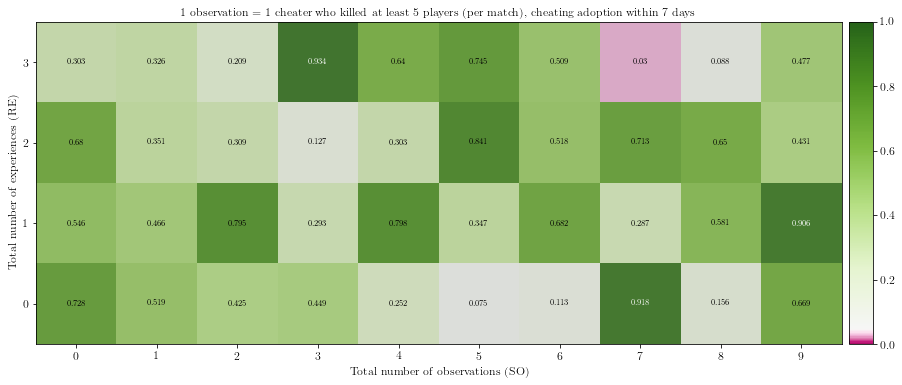

In [21]:
merged_df = pd.read_csv('data/SO_RE.csv')
test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

col_list = list(test_dat.columns[2:53])
res = test_dat.groupby([test_dat.total_exp, pd.cut(test_dat.total_obs, 
                                                   [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, np.inf], 
                                                   labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])])[col_list].sum().reset_index()

test_dat = res.groupby([res.total_obs, pd.cut(res.total_exp,[-np.inf, 0, 1, 2, np.inf], 
                                              labels = [0, 1, 2, 3])])[col_list].sum().reset_index()

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
print(test_dat.head())

piv = pd.pivot_table(test_dat, values="prob",index=["total_exp"], columns=["total_obs"])
print(piv)

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (SO)')
plt.ylabel('Total number of experiences (RE)')

textcolors = ["k", "w"]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.9 else 0])


cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/SO_RE_p_vals.png')

total_obs      0      1      2      3      4      5      6      7      8  \
sev_exp                                                                    
0          0.599  0.657  0.785  0.357  0.351  0.215  0.270  0.932  0.151   
1          0.847  0.085  0.281  0.164  0.814  0.489  0.330  0.187  0.402   
2          0.804  0.660  0.016  0.904  0.169  0.616  0.721  0.020  0.282   

total_obs      9  
sev_exp           
0          0.530  
1          0.927  
2          0.491  


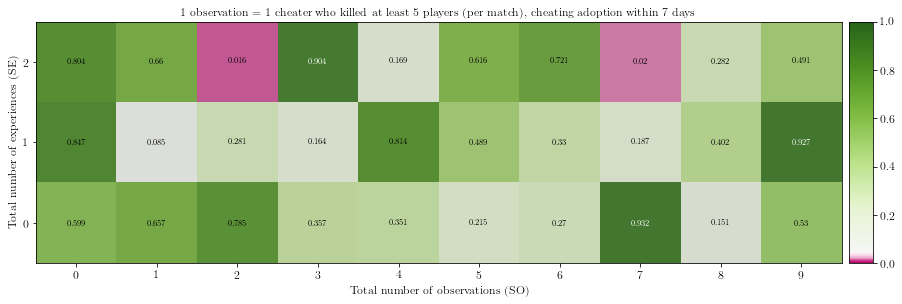

In [23]:
merged_df = pd.read_csv('data/SO_SE.csv')
test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

col_list = list(test_dat.columns[2:53])
res = test_dat.groupby([test_dat.sev_exp, pd.cut(test_dat.total_obs, 
                                                   [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, np.inf], 
                                                   labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])])[col_list].sum().reset_index()

test_dat = res.groupby([res.total_obs, pd.cut(res.sev_exp,[-np.inf, 0, 1, np.inf], 
                                              labels = [0, 1, 2])])[col_list].sum().reset_index()

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
# print(test_dat.head())

piv = pd.pivot_table(test_dat, values="prob",index=["sev_exp"], columns=["total_obs"])
print(piv)

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (SO)')
plt.ylabel('Total number of experiences (SE)')

textcolors = ["k", "w"]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.9 else 0])


cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/SO_SE_p_vals.png')

  total_obs total_exp      E     R1     R2     R3     R4     R5     R6     R7  \
0         0         0  183.0  179.0  183.0  163.0  181.0  174.0  169.0  180.0   
1         0         1  101.0  100.0  102.0  101.0  119.0   92.0  108.0  103.0   
2         0         2   22.0   27.0   25.0   24.0   27.0   20.0   28.0   20.0   
3         0         3   13.0    8.0   10.0   14.0    8.0   15.0   12.0    8.0   
4         1         0  381.0  406.0  391.0  415.0  399.0  400.0  416.0  405.0   

   ...    R45    R46    R47    R48    R49    R50  rand_mean    cdf    pmf  \
0  ...  166.0  179.0  174.0  186.0  174.0  173.0     176.86  0.695  0.027   
1  ...  105.0   95.0  104.0   99.0  112.0  102.0     102.64  0.462  0.039   
2  ...   19.0   30.0   25.0   29.0   23.0   19.0      23.14  0.461  0.082   
3  ...   10.0   11.0   13.0    9.0   11.0   13.0      11.20  0.762  0.096   
4  ...  389.0  393.0  397.0  391.0  404.0  394.0     397.72  0.209  0.014   

    prob  
0  0.332  
1  0.577  
2  0.622  
3  0.3

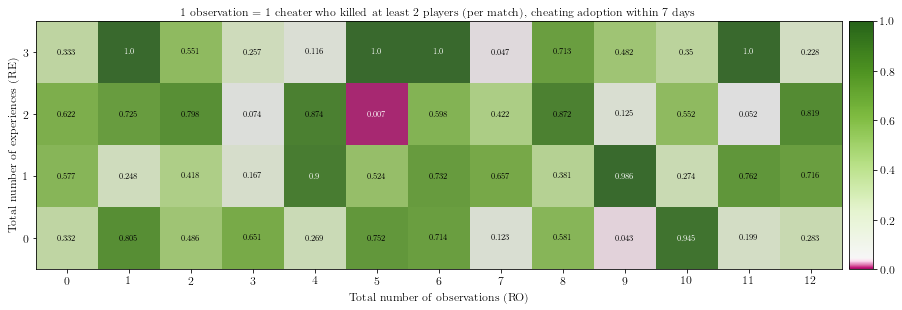

In [25]:
merged_df = pd.read_csv('data/RO_RE.csv')
test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

col_list = list(test_dat.columns[2:53])
res = test_dat.groupby([test_dat.total_exp, pd.cut(test_dat.total_obs, 
                                                   [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, np.inf], 
                                                   labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])])[col_list].sum().reset_index()

test_dat = res.groupby([res.total_obs, pd.cut(res.total_exp,[-np.inf, 0, 1, 2, np.inf], 
                                              labels = [0, 1, 2, 3])])[col_list].sum().reset_index()

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})

piv = pd.pivot_table(test_dat, values="prob",index=["total_exp"], columns=["total_obs"])
print(piv)

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 2 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (RO)')
plt.ylabel('Total number of experiences (RE)')

textcolors = ["k", "w"]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.9 else 0])


cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/RO_RE_p_vals.png')

total_obs     0      1      2      3      4      5      6      7      8   \
sev_exp                                                                    
0          0.321  0.786  0.484  0.316  0.469  0.693  0.900  0.418  0.795   
1          0.598  0.225  0.538  0.408  0.830  0.210  0.351  0.288  0.228   
2          0.760  1.000  0.381  0.359  0.222  0.259  0.844  0.005  0.829   

total_obs     9      10     11     12  
sev_exp                                
0          0.213  0.985  0.082  0.460  
1          0.687  0.057  0.852  0.662  
2          0.572  0.213  0.610  0.390  


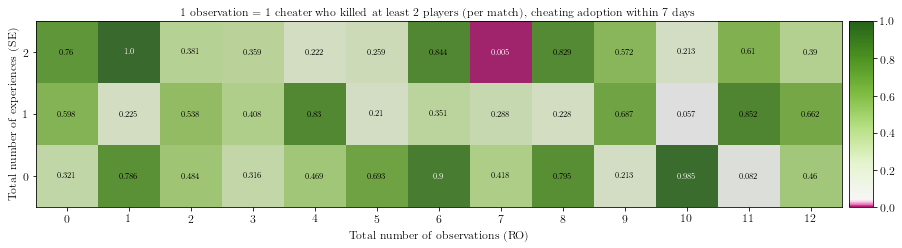

In [24]:
merged_df = pd.read_csv('data/RO_SE.csv')
test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

col_list = list(test_dat.columns[2:53])
res = test_dat.groupby([test_dat.sev_exp, pd.cut(test_dat.total_obs, 
                                                 [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, np.inf], 
                                                 labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])])[col_list].sum().reset_index()

test_dat = res.groupby([res.total_obs, pd.cut(res.sev_exp,[-np.inf, 0, 1, np.inf], 
                                              labels = [0, 1, 2])])[col_list].sum().reset_index()

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
# print(test_dat.head())

piv = pd.pivot_table(test_dat, values="prob",index=["sev_exp"], columns=["total_obs"])
print(piv)

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 2 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (RO)')
plt.ylabel('Total number of experiences (SE)')

textcolors = ["k", "w"]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.9 else 0])


cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/RO_SE_p_vals.png')

Plot the number of counts in cells.

In [11]:
freq_piv = pd.pivot_table(test_dat, values="E",index=["total_exp"], columns=["total_obs"])
print(freq_piv)

total_obs     0      1      2     3     4     5    6    7    8    9   ...  \
total_exp                                                             ...   
0          644.0  330.0  122.0  50.0  26.0  18.0  8.0  2.0  5.0  2.0  ...   
1          180.0  109.0   57.0  41.0  16.0  17.0  5.0  6.0  2.0  1.0  ...   
2           29.0   23.0   19.0  20.0  11.0   5.0  3.0  2.0  3.0  1.0  ...   
3           11.0    4.0    4.0   2.0   2.0   6.0  3.0  3.0  2.0  1.0  ...   
4            1.0    0.0    1.0   1.0   3.0   0.0  1.0  2.0  1.0  0.0  ...   
5            3.0    0.0    0.0   0.0   2.0   0.0  1.0  2.0  1.0  0.0  ...   
6            0.0    NaN    NaN   0.0   0.0   0.0  0.0  0.0  1.0  0.0  ...   
7            0.0    NaN    0.0   NaN   0.0   0.0  0.0  0.0  0.0  0.0  ...   
8            NaN    NaN    NaN   NaN   0.0   0.0  NaN  NaN  0.0  NaN  ...   
9            NaN    NaN    NaN   NaN   NaN   NaN  NaN  NaN  0.0  NaN  ...   
10           NaN    NaN    NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  ...   

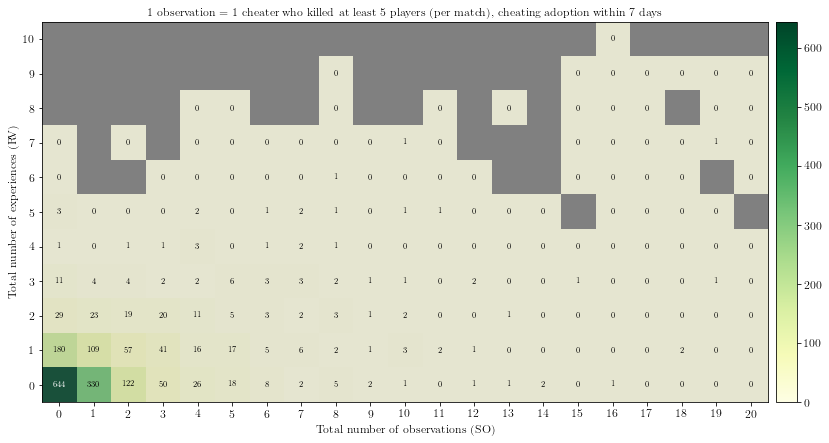

In [13]:
fig, ax = plt.subplots()
img1 = ax.imshow(freq_piv, cmap='YlGn', alpha=0.8)
ax.set_xticks(np.arange(freq_piv.shape[1]))
ax.set_yticks(np.arange(freq_piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (SO)')
plt.ylabel('Total number of experiences (RV)')

textcolors = ["k", "w"]

for y in range(freq_piv.shape[0]):
    for x in range(freq_piv.shape[1]):
        if np.isnan(freq_piv[x][y]) == False:
            text = ax.text(x, y, int(freq_piv[x][y]), ha="center", va="center",
                           color=textcolors[1 if freq_piv[x][y] >= 400 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/SO_RV_freq.png')

Plot a heatmap of strict experiences and relaxed/strict observations.

In [22]:
merged_df = pd.read_csv('data/SV_RO.csv')
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)

test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
print(test_dat.head())

   total_obs  sev_exp      E     R1     R2     R3     R4     R5     R6     R7  \
0          0        0  269.0  259.0  269.0  246.0  281.0  254.0  260.0  258.0   
1          1        0  412.0  440.0  427.0  449.0  427.0  433.0  444.0  436.0   
2          2        0  254.0  247.0  244.0  239.0  243.0  255.0  236.0  240.0   
3          3        0  165.0  156.0  167.0  164.0  169.0  155.0  160.0  143.0   
4          4        0  114.0  105.0  115.0  113.0  104.0  122.0  104.0  115.0   

   ...    R45    R46    R47    R48    R49    R50  rand_mean    cdf    pmf  \
0  ...  259.0  256.0  258.0  276.0  268.0  262.0     260.94  0.704  0.021   
1  ...  415.0  420.0  429.0  420.0  426.0  432.0     429.74  0.203  0.014   
2  ...  261.0  258.0  253.0  254.0  251.0  236.0     248.18  0.659  0.023   
3  ...  164.0  177.0  156.0  158.0  168.0  175.0     161.94  0.615  0.030   
4  ...  110.0  104.0  106.0  108.0  105.0  107.0     110.08  0.668  0.035   

    prob  
0  0.317  
1  0.810  
2  0.364  
3  0.4

In [58]:
piv = pd.pivot_table(test_dat, values="prob",index=["sev_exp"], columns=["total_obs"])
print(piv)

total_obs     0      1      2      3      4      5      6      7      8   \
sev_exp                                                                    
0          0.317  0.810  0.364  0.415  0.367  0.803  0.876  0.497  0.743   
1          0.598  0.226  0.461  0.489  0.829  0.214  0.347  0.286  0.191   
2          0.812  1.000  0.381  0.129  0.494  0.275  0.802  0.036  0.853   
3          0.493    NaN    NaN  1.000  1.000  0.077  1.000  0.197  0.012   
4          1.000    NaN    NaN    NaN    NaN    NaN    NaN  1.000  1.000   
5            NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

total_obs     9   ...     11     12     13     14     15     16     17     18  \
sev_exp           ...                                                           
0          0.331  ...  0.077  0.620  0.583  0.910  0.397  0.562  0.815  0.492   
1          0.763  ...  0.850  0.779  0.559  0.457  0.402  0.031  0.603  0.636   
2          1.000  ...  0.442  0.674  0.743  1.000  0.469  1.000  1.

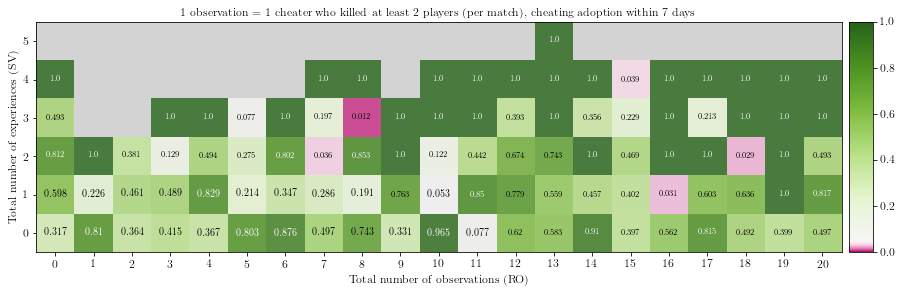

In [59]:
freq_piv = pd.pivot_table(test_dat, values="E",index=["sev_exp"], columns=["total_obs"])

# Plot a heatmap.
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 2 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (RO)')
plt.ylabel('Total number of experiences (SV)')

textcolors = ["k", "w"]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= 0.01 or piv[x][y] >= 0.8 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/SV_RO_p_vals.png')

In [23]:
freq_piv = pd.pivot_table(test_dat, values="E",index=["sev_exp"], columns=["total_obs"])
print(freq_piv)

total_obs     0      1      2      3      4     5     6     7     8     9   \
sev_exp                                                                      
0          269.0  412.0  254.0  165.0  114.0  66.0  48.0  44.0  27.0  28.0   
1           45.0   28.0   24.0   23.0   17.0  21.0  17.0  18.0  19.0   9.0   
2            4.0    0.0    1.0    3.0    2.0   3.0   1.0   5.0   2.0   0.0   
3            1.0    NaN    NaN    0.0    0.0   1.0   0.0   1.0   3.0   0.0   
4            0.0    NaN    NaN    NaN    NaN   NaN   NaN   0.0   0.0   NaN   
5            NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   

total_obs  ...    11   12   13   14   15   16   17   18   19   20  
sev_exp    ...                                                     
0          ...  15.0  9.0  6.0  4.0  7.0  7.0  2.0  3.0  3.0  3.0  
1          ...   3.0  3.0  3.0  6.0  4.0  8.0  3.0  2.0  0.0  1.0  
2          ...   2.0  1.0  1.0  0.0  2.0  0.0  0.0  3.0  0.0  1.0  
3          ...   0.0  1.0  0.0  1.0

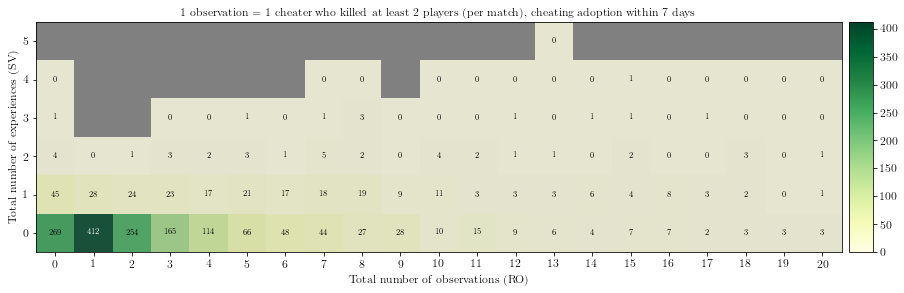

In [24]:
fig, ax = plt.subplots()
img1 = ax.imshow(freq_piv, cmap='YlGn', alpha=0.8)
ax.set_xticks(np.arange(freq_piv.shape[1]))
ax.set_yticks(np.arange(freq_piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 2 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (RO)')
plt.ylabel('Total number of experiences (SV)')

textcolors = ["k", "w"]

for y in range(freq_piv.shape[0]):
    for x in range(freq_piv.shape[1]):
        if np.isnan(freq_piv[x][y]) == False:
            text = ax.text(x, y, int(freq_piv[x][y]), ha="center", va="center",
                           color=textcolors[1 if freq_piv[x][y] >= 300 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/2_RO_SV_freq.png')

Plot a cumulative proportion heatmap.

In [42]:
merged_df = pd.read_csv('data/RV_SO.csv')
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)
# merged_df = merged_df.drop(merged_df[merged_df.total_exp > 8].index)

test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
test_dat['count'] = (test_dat.iloc[:, 3:].values >= test_dat[['E']].values).sum(axis=1).astype(int)
test_dat['cum_prop'] = test_dat['count'] / 50

test_dat = test_dat.round({"cum_prop":2})
print(test_dat.head())

   total_obs  total_exp      E     R1     R2     R3     R4     R5     R6  \
0          0          0  644.0  653.0  664.0  644.0  651.0  648.0  652.0   
1          1          0  330.0  339.0  323.0  337.0  343.0  340.0  318.0   
2          2          0  122.0  122.0  126.0  117.0  112.0  122.0  123.0   
3          3          0   50.0   37.0   52.0   52.0   55.0   46.0   40.0   
4          4          0   26.0   35.0   33.0   25.0   21.0   30.0   28.0   

      R7  ...    R43    R44    R45    R46    R47    R48    R49    R50  count  \
0  670.0  ...  670.0  654.0  636.0  677.0  664.0  647.0  660.0  646.0     44   
1  308.0  ...  348.0  327.0  328.0  319.0  319.0  354.0  337.0  327.0     32   
2  117.0  ...  114.0  114.0  127.0  119.0  123.0  117.0  116.0  134.0     23   
3   50.0  ...   49.0   45.0   54.0   57.0   46.0   41.0   50.0   46.0     23   
4   19.0  ...   20.0   28.0   21.0   21.0   23.0   22.0   23.0   19.0     13   

   cum_prop  
0      0.88  
1      0.64  
2      0.46  
3     

In [43]:
cum_prop = pd.pivot_table(test_dat, values="cum_prop",index=["total_exp"], columns=["total_obs"])
print(cum_prop)

total_obs    0     1     2     3     4     5     6     7     8     9   ...  \
total_exp                                                              ...   
0          0.88  0.64  0.46  0.46  0.26  0.04  0.22  0.84  0.22  0.74  ...   
1          0.54  0.50  0.92  0.22  0.90  0.30  0.68  0.34  0.88  0.96  ...   
2          0.70  0.44  0.22  0.02  0.46  0.90  0.62  0.72  0.32  0.88  ...   
3          0.26  0.30  0.36  0.96  0.92  0.32  0.38  0.20  0.44  0.72  ...   
4          0.94  1.00  0.34  0.74  0.32  1.00  0.82  0.20  0.62  1.00  ...   
5          0.08  1.00  1.00  1.00  0.12  1.00  0.42  0.02  0.30  1.00  ...   
6          1.00   NaN   NaN  1.00  1.00  1.00  1.00  1.00  0.18  1.00  ...   
7          1.00   NaN  1.00   NaN  1.00  1.00  1.00  1.00  1.00  1.00  ...   
8           NaN   NaN   NaN   NaN  1.00  1.00   NaN   NaN  1.00   NaN  ...   
9           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  1.00   NaN  ...   
10          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN 

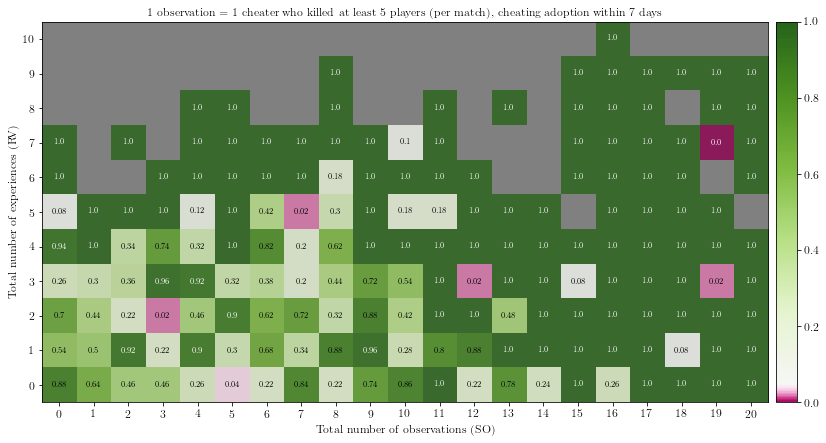

In [44]:
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(cum_prop, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(cum_prop.shape[1]))
ax.set_yticks(np.arange(cum_prop.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (SO)')
plt.ylabel('Total number of experiences (RV)')

textcolors = ["k", "w"]

for y in range(cum_prop.shape[0]):
    for x in range(cum_prop.shape[1]):
        if np.isnan(cum_prop[x][y]) == False:
            text = ax.text(x, y, cum_prop[x][y], ha="center", va="center",
                           color=textcolors[1 if cum_prop[x][y] <= 0.01 or cum_prop[x][y] >= 0.9 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/3_SO_RV_cum_prop.png')

In [48]:
merged_df = pd.read_csv('data/SV_RO.csv')
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)
# merged_df = merged_df.drop(merged_df[merged_df.total_exp > 8].index)

test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
test_dat['count'] = (test_dat.iloc[:, 3:].values >= test_dat[['E']].values).sum(axis=1).astype(int)
test_dat['cum_prop'] = test_dat['count'] / 50

test_dat = test_dat.round({"cum_prop":2})
print(test_dat.head())

   total_obs  sev_exp      E     R1     R2     R3     R4     R5     R6     R7  \
0          0        0  269.0  259.0  269.0  246.0  281.0  254.0  260.0  258.0   
1          1        0  412.0  440.0  427.0  449.0  427.0  433.0  444.0  436.0   
2          2        0  254.0  247.0  244.0  239.0  243.0  255.0  236.0  240.0   
3          3        0  165.0  156.0  167.0  164.0  169.0  155.0  160.0  143.0   
4          4        0  114.0  105.0  115.0  113.0  104.0  122.0  104.0  115.0   

   ...    R43    R44    R45    R46    R47    R48    R49    R50  count  \
0  ...  265.0  268.0  259.0  256.0  258.0  276.0  268.0  262.0      9   
1  ...  441.0  435.0  415.0  420.0  429.0  420.0  426.0  432.0     49   
2  ...  251.0  234.0  261.0  258.0  253.0  254.0  251.0  236.0     12   
3  ...  167.0  166.0  164.0  177.0  156.0  158.0  168.0  175.0     18   
4  ...  101.0  104.0  110.0  104.0  106.0  108.0  105.0  107.0     16   

   cum_prop  
0      0.18  
1      0.98  
2      0.24  
3      0.36  
4   

In [49]:
cum_prop = pd.pivot_table(test_dat, values="cum_prop",index=["sev_exp"], columns=["total_obs"])
print(cum_prop)

total_obs    0     1     2     3     4     5     6     7     8     9   ...  \
sev_exp                                                                ...   
0          0.18  0.98  0.24  0.36  0.32  0.88  0.90  0.48  0.82  0.40  ...   
1          0.62  0.14  0.42  0.46  0.82  0.18  0.28  0.30  0.14  0.84  ...   
2          0.82  1.00  0.40  0.10  0.46  0.30  0.82  0.02  0.92  1.00  ...   
3          0.50   NaN   NaN  1.00  1.00  0.08  1.00  0.18  0.00  1.00  ...   
4          1.00   NaN   NaN   NaN   NaN   NaN   NaN  1.00  1.00   NaN  ...   
5           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

total_obs   11    12    13    14    15    16    17    18    19    20  
sev_exp                                                               
0          0.1  0.74  0.68  0.94  0.44  0.56  0.86  0.50  0.38  0.48  
1          0.9  0.84  0.58  0.48  0.38  0.04  0.62  0.60  1.00  0.88  
2          0.5  0.72  0.76  1.00  0.52  1.00  1.00  0.04  1.00  0.56  
3          1.0  0.40

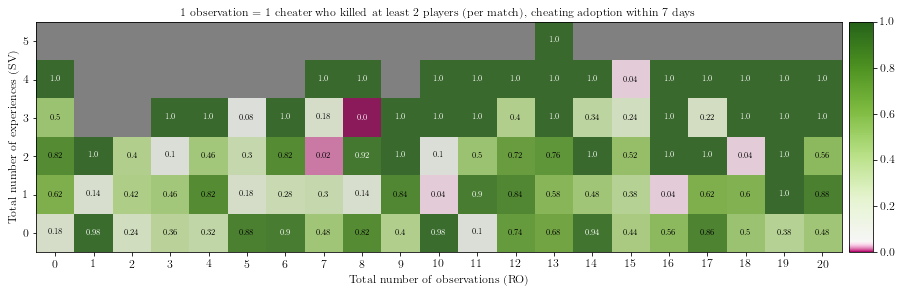

In [50]:
norm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)

fig, ax = plt.subplots()
img1 = ax.imshow(cum_prop, alpha=0.8, norm=norm)
ax.set_xticks(np.arange(cum_prop.shape[1]))
ax.set_yticks(np.arange(cum_prop.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 2 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations (RO)')
plt.ylabel('Total number of experiences (SV)')

textcolors = ["k", "w"]

for y in range(cum_prop.shape[0]):
    for x in range(cum_prop.shape[1]):
        if np.isnan(cum_prop[x][y]) == False:
            text = ax.text(x, y, cum_prop[x][y], ha="center", va="center",
                           color=textcolors[1 if cum_prop[x][y] <= 0.01 or cum_prop[x][y] >= 0.9 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/2_RO_SV_cum_prop.png')

Plot a cumulative frequency heatmap.

In [25]:
arr = np.array(freq)
emp_cumsum = np.cumsum(np.cumsum(arr, axis=0),axis=1)
print(emp_cumsum)

[[ 644  974 1096 1146 1172 1190 1198 1200 1205 1207 1208 1208 1209 1210
  1212 1212 1213 1213 1213 1213 1213]
 [ 824 1263 1442 1533 1575 1610 1623 1631 1638 1641 1645 1647 1649 1650
  1652 1652 1653 1653 1655 1655 1655]
 [ 853 1315 1513 1624 1677 1717 1733 1743 1753 1757 1763 1765 1767 1769
  1771 1771 1772 1772 1774 1774 1774]
 [ 864 1330 1532 1645 1700 1746 1765 1778 1790 1795 1802 1804 1808 1810
  1812 1813 1814 1814 1816 1817 1817]
 [ 865 1331 1534 1648 1706 1752 1772 1787 1800 1805 1812 1814 1818 1820
  1822 1823 1824 1824 1826 1827 1827]
 [ 868 1334 1537 1651 1711 1757 1778 1795 1809 1814 1822 1825 1829 1831
  1833 1834 1835 1835 1837 1838 1838]
 [ 868 1334 1537 1651 1711 1757 1778 1795 1810 1815 1823 1826 1830 1832
  1834 1835 1836 1836 1838 1839 1839]
 [ 868 1334 1537 1651 1711 1757 1778 1795 1810 1815 1824 1827 1831 1833
  1835 1836 1837 1837 1839 1841 1841]
 [ 868 1334 1537 1651 1711 1757 1778 1795 1810 1815 1824 1827 1831 1833
  1835 1836 1837 1837 1839 1841 1841]]


In [31]:
freq = pd.pivot_table(test_dat, values="R1",index=["total_exp"], columns=["total_obs"], fill_value=0)
print(freq)

arr = np.array(freq)
ran_cumsum = np.cumsum(np.cumsum(arr, axis=0),axis=1)
print(ran_cumsum)

for i in range(2, 6):
    freq = pd.pivot_table(test_dat, values="R" + str(i),index=["total_exp"], columns=["total_obs"], fill_value=0)
    arr = np.array(freq)
    temp_cumsum = np.cumsum(np.cumsum(arr, axis=0),axis=1)
    ran_cumsum += temp_cumsum
    
print(ran_cumsum)

rand_mean = ran_cumsum / 5
cdf_mat = scipy.stats.poisson.cdf(emp_cumsum, rand_mean)
pmf_mat = scipy.stats.poisson.pmf(emp_cumsum, rand_mean)
prob_mat = 1 - cdf_mat + pmf_mat

prob_mat = prob_mat.round(3)
print(prob_mat)

total_obs   0    1    2   3   4   5   6   7   8   9   ...  11  12  13  14  15  \
total_exp                                             ...                       
0          653  339  122  37  35   7   6   3   6   2  ...   0   0   1   0   0   
1          181  111   70  29  19  11   6   3   4   2  ...   3   1   0   1   1   
2           35   23   15  12  15  12   2   2   3   0  ...   0   1   2   1   0   
3            7    3    0   3   4   6   5   2   2   0  ...   1   1   2   0   0   
4            1    1    0   1   2   2   0   1   1   0  ...   0   0   0   0   0   
5            2    0    0   0   2   0   0   1   0   0  ...   0   0   0   0   0   
6            0    0    0   0   0   0   0   0   0   1  ...   0   0   0   0   0   
7            0    0    0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
8            0    0    0   0   1   0   0   0   0   0  ...   0   0   0   0   0   

total_obs  16  17  18  19  20  
total_exp                      
0           0   0   0   0   1  
1           

In [35]:
cum_piv = pd.DataFrame(data=prob_mat).rename_axis(index='total_exp', columns='total_obs')
print(cum_piv)

total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.628  0.681  0.647  0.626  0.655  0.568  0.543  0.550  0.536   
1          0.660  0.648  0.681  0.546  0.633  0.505  0.499  0.480  0.489   
2          0.697  0.696  0.697  0.509  0.586  0.486  0.494  0.476  0.475   
3          0.689  0.674  0.659  0.493  0.578  0.463  0.480  0.441  0.437   
4          0.705  0.690  0.670  0.503  0.587  0.492  0.511  0.458  0.452   
5          0.676  0.666  0.648  0.482  0.563  0.467  0.484  0.417  0.406   
6          0.676  0.666  0.648  0.482  0.563  0.467  0.484  0.419  0.403   
7          0.676  0.666  0.648  0.482  0.565  0.471  0.488  0.423  0.406   
8          0.676  0.666  0.648  0.482  0.566  0.473  0.490  0.424  0.408   

total_obs     9   ...     11     12     13     14     15     16     17     18  \
total_exp         ...                                                           
0

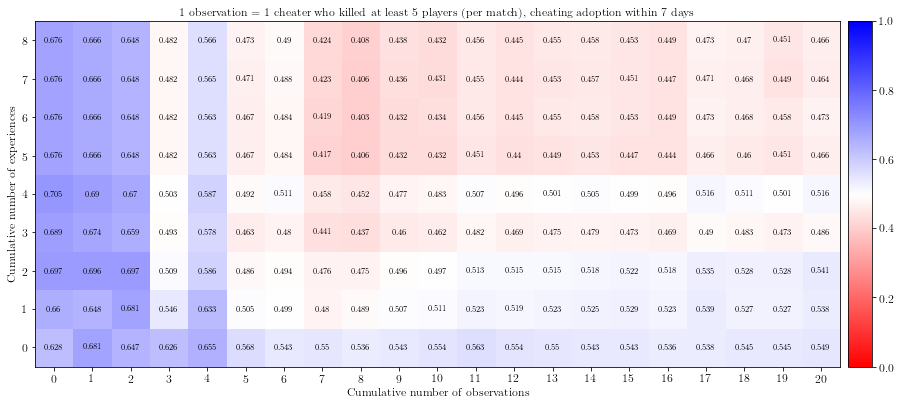

In [43]:
fig, ax = plt.subplots()
norm = DivergingNorm(vmin=0, vcenter=0.5, vmax=1)
img1 = ax.imshow(cum_piv, norm=norm)
ax.set_xticks(np.arange(cum_piv.shape[1]))
ax.set_yticks(np.arange(cum_piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Cumulative number of observations')
plt.ylabel('Cumulative number of experiences')

textcolors = ["k", "w"]

for y in range(cum_piv.shape[0]):
    for x in range(cum_piv.shape[1]):
        if np.isnan(cum_piv[x][y]) == False:
            text = ax.text(x, y, cum_piv[x][y], ha="center", va="center",
                           color=textcolors[1 if cum_piv[x][y] <= 0.1 or cum_piv[x][y] >= 0.9 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")
plt.show()
fig.savefig('figs/cum_cnt_p_vals.png')